# Visualization Demo: GT Masks and Grad-CAM

This notebook visualizes:
1.  **Ground Truth Masks**: The 5-channel cluster masks generated from the LSMI dataset, overlaid on the original images.
2.  **Grad-CAM Heatmaps**: The attention maps from the pre-trained IlluminantCNN model for each illuminant cluster.
3.  **Model Predictions**: The classification output of the model for the main illuminant.


In [12]:
import os
import json
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from illuminant_estimation.models.cnn import IlluminantCNN
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Constants
LSMI_ROOT = "Data/LSMI/nikon"
MASK_ROOT = "Data/LSMI_Masks"
MODEL_PATH = "best_illuminant_cnn_val_8084.pth"
CLUSTER_NAMES = ['Very_Warm', 'Warm', 'Neutral', 'Cool', 'Very_Cool']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Meta Data
try:
    with open(os.path.join(LSMI_ROOT, "meta.json"), "r") as f:
        META_DATA = json.load(f)
    print("Loaded meta.json")
except Exception as e:
    print(f"Error loading meta.json: {e}")
    META_DATA = {}

print(f"Using device: {DEVICE}")

Loaded meta.json
Using device: cuda


## 1. Visualize Ground Truth Masks

We overlay the 5-channel masks on the original images. Each channel corresponds to a cluster.

Visualizing Place0...


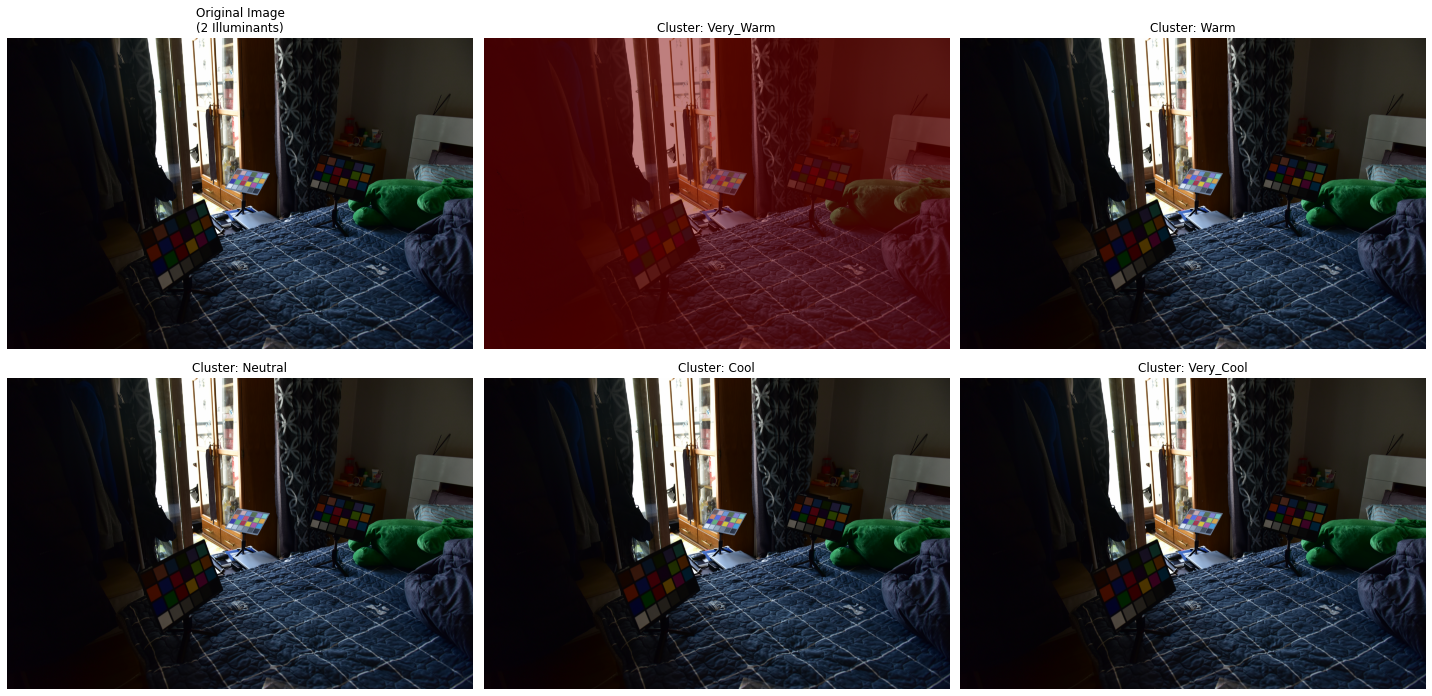

Visualizing Place10...


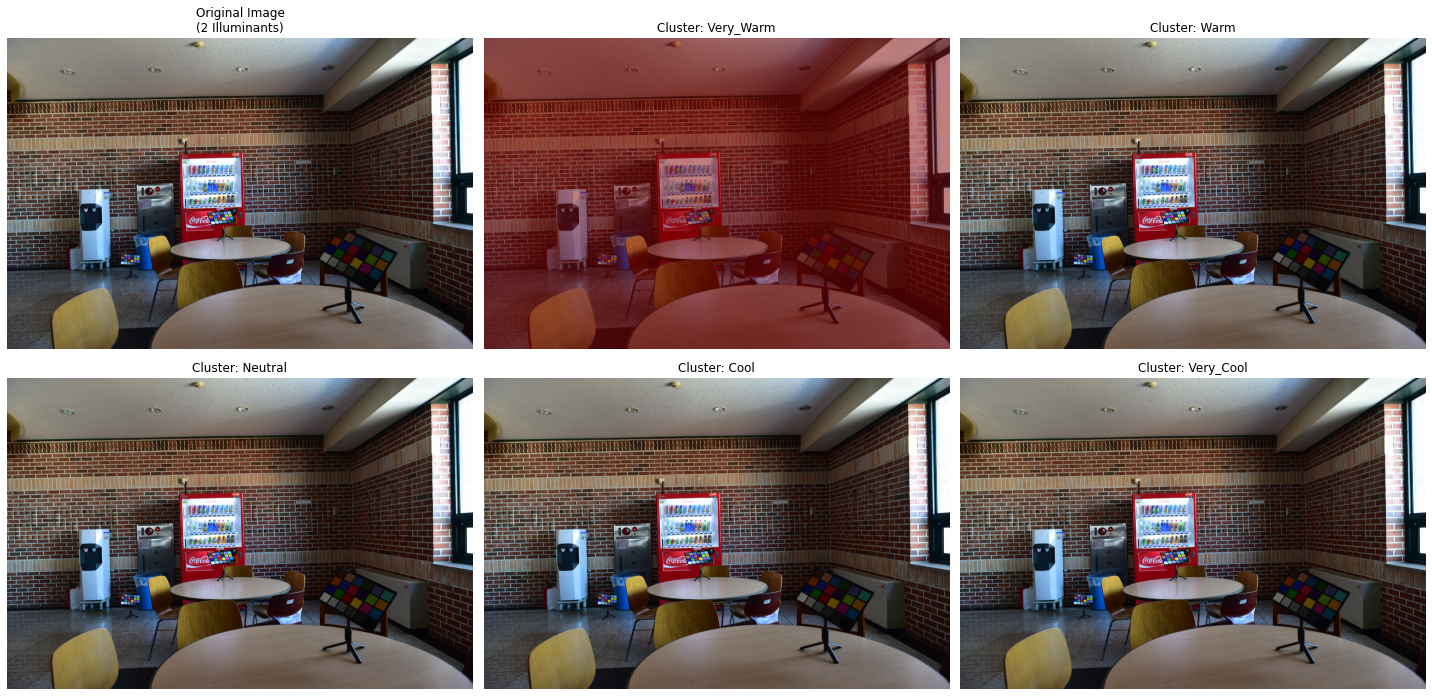

Visualizing Place20...


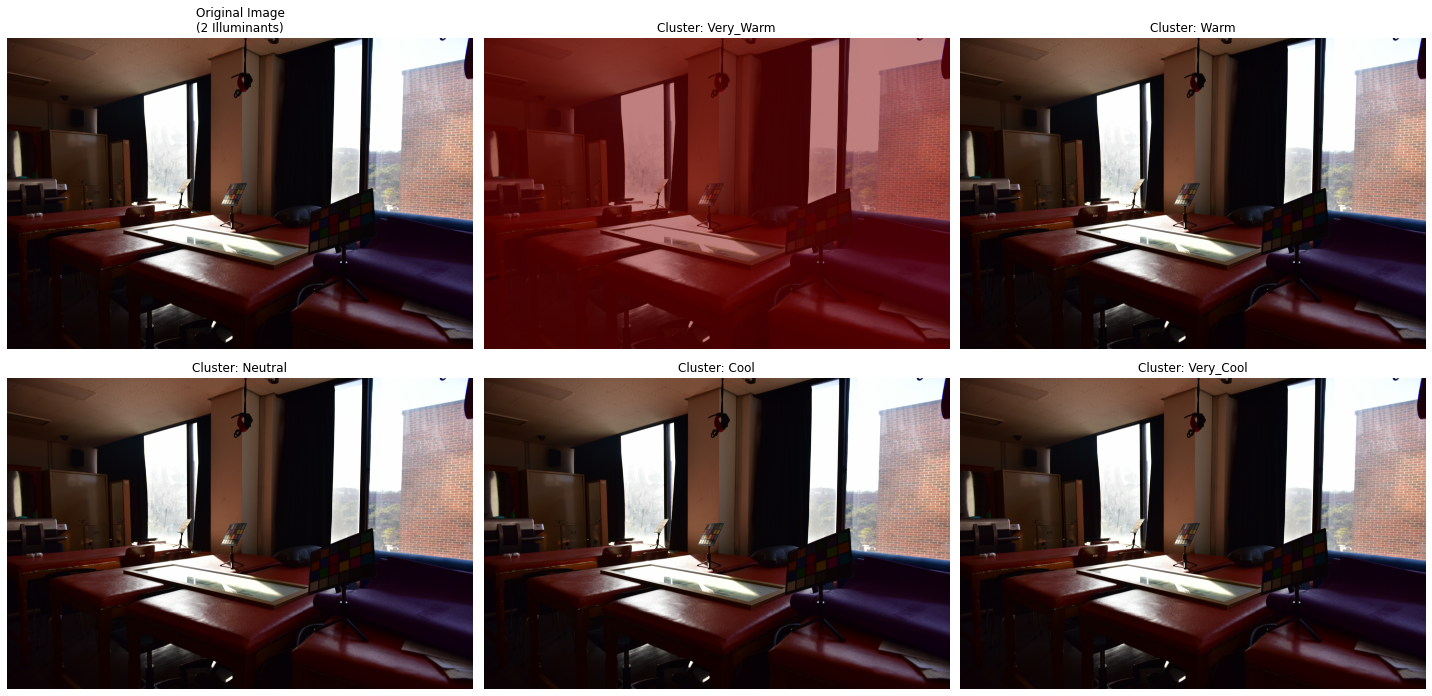

In [15]:
def visualize_gt_masks(place_name, max_alpha=0.5):
    # Load Image (using the _1.jpg for visualization if available, else convert NEF)
    image_path = os.path.join(LSMI_ROOT, place_name, f"{place_name}_1.jpg")
    if not os.path.exists(image_path):
        # Fallback to NEF if JPG doesn't exist (using rawpy)
        import rawpy
        nef_path = os.path.join(LSMI_ROOT, place_name, f"{place_name}_1.nef")
        with rawpy.imread(nef_path) as raw:
            rgb = raw.postprocess(use_camera_wb=True)
            image = Image.fromarray(rgb)
    else:
        image = Image.open(image_path).convert("RGB")
    
    image = np.array(image)
    
    # Load Mask
    mask_path = os.path.join(MASK_ROOT, f"{place_name}_mask.npy")
    if not os.path.exists(mask_path):
        print(f"Mask not found for {place_name}")
        return
    
    mask = np.load(mask_path)
    # Resize mask to image size if needed (mask is from half-size raw usually)
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
    # Get Num Lights
    num_lights = META_DATA.get(place_name, {}).get("NumOfLights", "Unknown")

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title(f"Original Image\n({num_lights} Illuminants)")
    plt.axis('off')
    
    for i in range(5):
        plt.subplot(2, 3, i+2)
        
        # Create colored overlay for this cluster
        heatmap = mask[:, :, i]
        
        # Normalize heatmap for color mapping (0-1)
        # We want the color to be consistent, so we map 0-1 to the colormap
        heatmap_norm = np.clip(heatmap, 0, 1)
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_norm), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Smart Blending: Opacity proportional to mask value
        # alpha_channel = mask_value * max_alpha
        alpha_mask = heatmap_norm * max_alpha
        alpha_mask = np.expand_dims(alpha_mask, axis=-1) # (H, W, 1)
        
        # Blend: result = image * (1 - alpha) + overlay * alpha
        overlay = (image * (1 - alpha_mask) + heatmap_colored * alpha_mask).astype(np.uint8)
        
        plt.imshow(overlay)
        plt.title(f"Cluster: {CLUSTER_NAMES[i]}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize a few samples
samples = ['Place0', 'Place10', 'Place20'] # Adjust based on available data
for s in samples:
    print(f"Visualizing {s}...")
    try:
        visualize_gt_masks(s)
    except Exception as e:
        print(f"Error visualizing {s}: {e}")

## 2. Visualize Grad-CAM Heatmaps

We run the pre-trained model on the images and generate Grad-CAM heatmaps for each class.

Generating Grad-CAM for Place0...
Loaded trained model.


/tmp/ipykernel_70203/1552033124.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


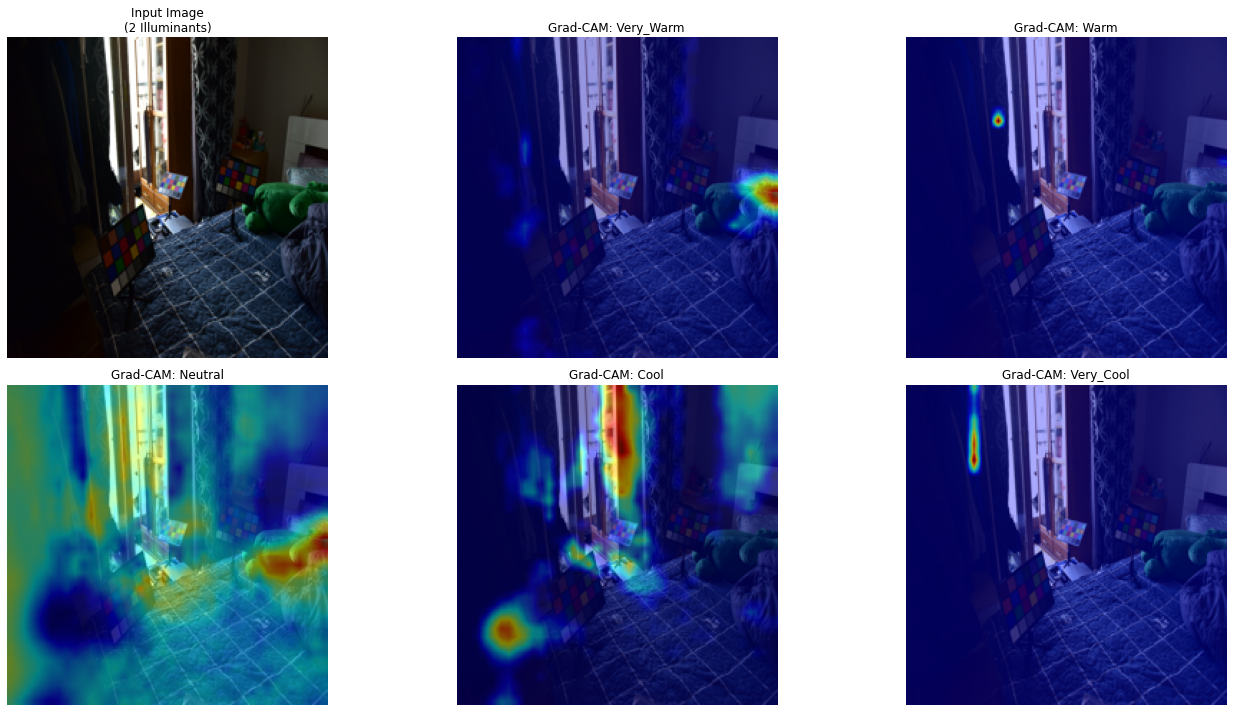

Generating Grad-CAM for Place10...
Loaded trained model.


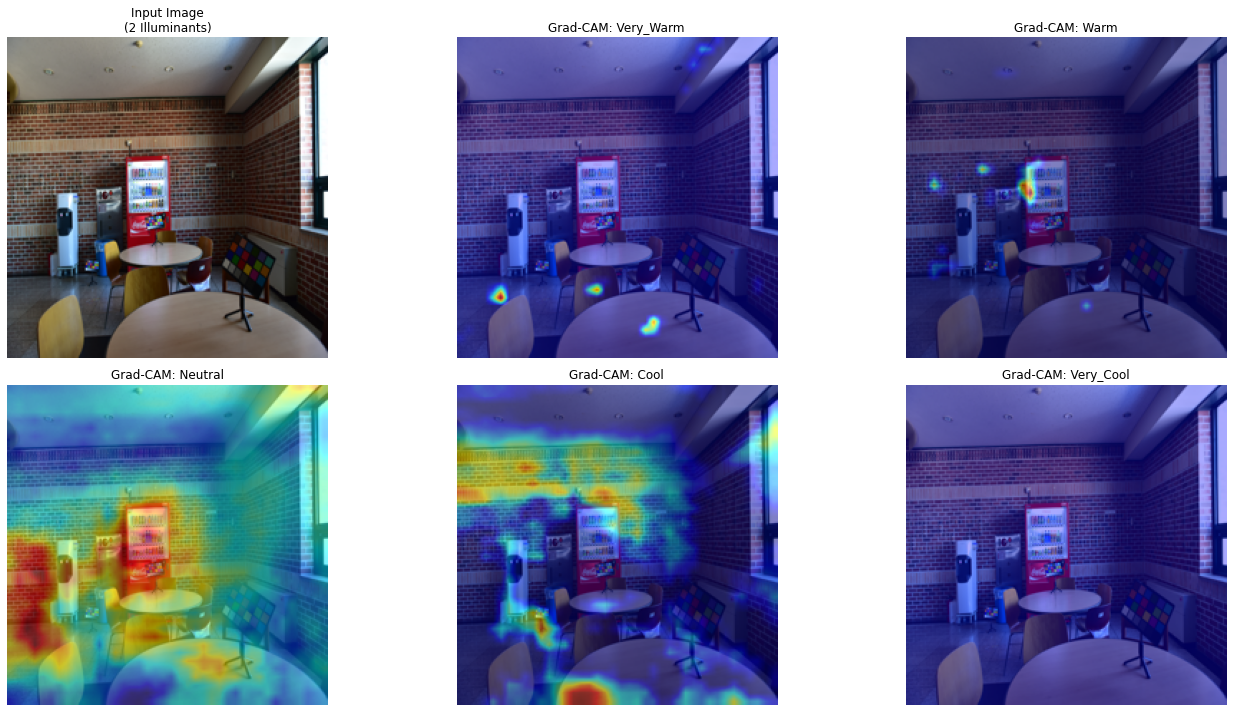

Generating Grad-CAM for Place20...
Loaded trained model.


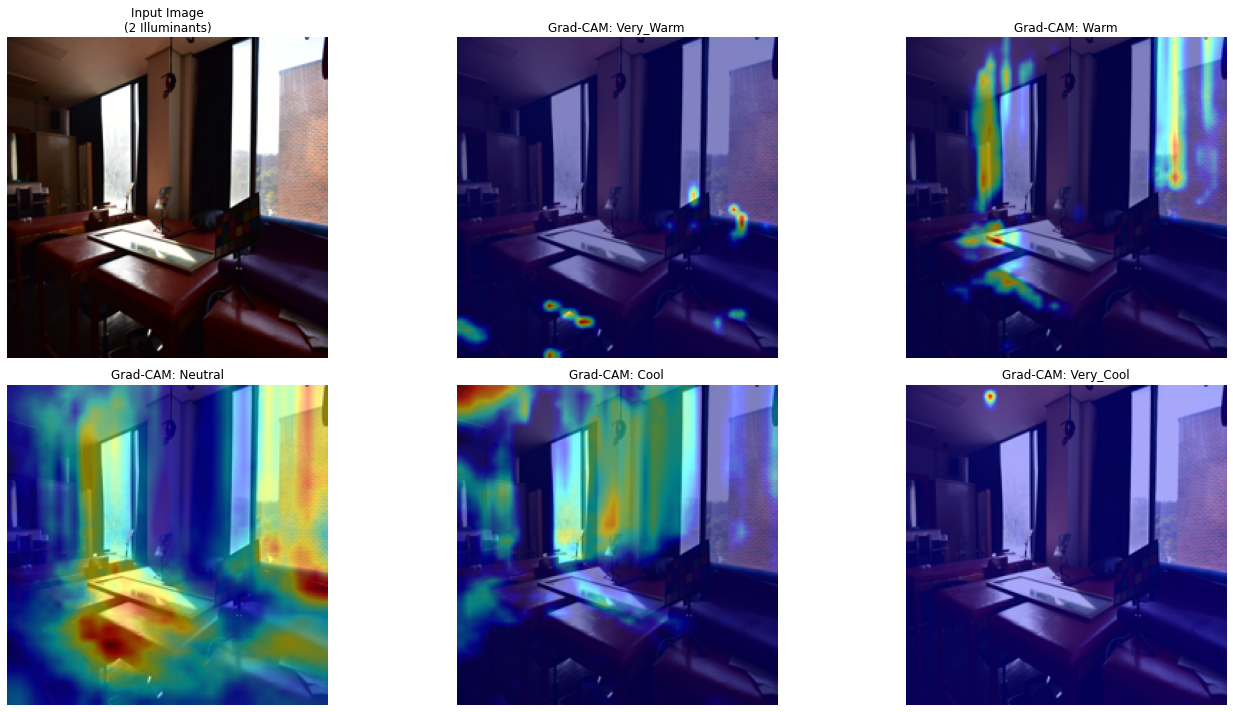

In [13]:
def visualize_gradcam(place_name):
    # Load Model
    model = IlluminantCNN(num_classes=5).to(DEVICE)
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print("Loaded trained model.")
    else:
        print(f"Warning: Pre-trained model not found at {MODEL_PATH}. Using random weights for demonstration.")
    model.eval()
    
    # Prepare Image
    image_path = os.path.join(LSMI_ROOT, place_name, f"{place_name}_1.jpg")
    if not os.path.exists(image_path):
         # Fallback to NEF
        import rawpy
        nef_path = os.path.join(LSMI_ROOT, place_name, f"{place_name}_1.nef")
        with rawpy.imread(nef_path) as raw:
            rgb = raw.postprocess(use_camera_wb=True)
            image_pil = Image.fromarray(rgb)
    else:
        image_pil = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    
    # Grad-CAM
    target_layers = [model.conv5]
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # Prepare image for visualization (float 0-1)
    rgb_img = np.array(image_pil.resize((224, 224))) / 255.0
    
    # Get Num Lights
    num_lights = META_DATA.get(place_name, {}).get("NumOfLights", "Unknown")

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f"Input Image\n({num_lights} Illuminants)")
    plt.axis('off')
    
    for i in range(5):
        targets = [ClassifierOutputTarget(i)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        plt.subplot(2, 3, i+2)
        plt.imshow(visualization)
        plt.title(f"Grad-CAM: {CLUSTER_NAMES[i]}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize Grad-CAM for the same samples
for s in samples:
    print(f"Generating Grad-CAM for {s}...")
    try:
        visualize_gradcam(s)
    except Exception as e:
        print(f"Error processing {s}: {e}")

## 3. Model Predictions

We display the model's prediction for the main illuminant class and the confidence scores for all classes.

In [14]:
def get_model_prediction(place_name):
    # Load Model
    model = IlluminantCNN(num_classes=5).to(DEVICE)
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    else:
        print(f"Warning: Pre-trained model not found at {MODEL_PATH}. Using random weights.")
    model.eval()

    # Load Image
    image_path = os.path.join(LSMI_ROOT, place_name, f"{place_name}_1.jpg")
    if not os.path.exists(image_path):
        # Fallback
        import rawpy
        nef_path = os.path.join(LSMI_ROOT, place_name, f"{place_name}_1.nef")
        with rawpy.imread(nef_path) as raw:
            rgb = raw.postprocess(use_camera_wb=True)
            image_pil = Image.fromarray(rgb)
    else:
        image_pil = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
        pred_idx = torch.argmax(probs).item()

    return CLUSTER_NAMES[pred_idx], probs.cpu().numpy()

print(f"{'Place':<10} | {'Prediction':<15} | {'Confidence Scores'}")
print("-" * 100)
for s in samples:
    try:
        pred_class, probs = get_model_prediction(s)
        probs_str = ", ".join([f"{n}: {p:.2f}" for n, p in zip(CLUSTER_NAMES, probs)])
        print(f"{s:<10} | {pred_class:<15} | {probs_str}")
    except Exception as e:
        print(f"{s:<10} | Error: {e}")

Place      | Prediction      | Confidence Scores
----------------------------------------------------------------------------------------------------


/tmp/ipykernel_70203/2151263107.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Place0     | Very_Warm       | Very_Warm: 0.53, Warm: 0.25, Neutral: 0.20, Cool: 0.00, Very_Cool: 0.02
Place10    | Warm            | Very_Warm: 0.04, Warm: 0.61, Neutral: 0.31, Cool: 0.01, Very_Cool: 0.02
Place20    | Warm            | Very_Warm: 0.07, Warm: 0.78, Neutral: 0.07, Cool: 0.01, Very_Cool: 0.07
